<a href="https://colab.research.google.com/github/Dragonblaze242/.emacs.d/blob/master/Final_Year_Project(MCKV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Dependencies**


In [1]:
!pip install dlib
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
from copy import deepcopy
import skimage
import cv2
import dlib
import numpy as np
import html
import PIL
import io

**Connect Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Image Function**

In [3]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

**Caffe Model**

In [4]:
caffeConfigFile = "/content/drive/MyDrive/Models/deploy.prototxt"
caffeWeightFile = "/content/drive/MyDrive/Models/res10_300x300_ssd_iter_140000.caffemodel"

**Detect Face & Draw Box**
(*It's also returns croped face frame*)

In [5]:
def detectDraw(Frame, Threshold = 0.5, Net = cv2.dnn.readNetFromCaffe(caffeConfigFile, caffeWeightFile)):
  if Net.empty():
    print("[ERROR] Unable to load model.")
    return None
  inputblob = cv2.dnn.blobFromImage(cv2.resize(Frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  Net.setInput(inputblob)
  detections = Net.forward()
  (height, width) = Frame.shape[:2]
  Crop = None
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > Threshold:
      box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
      (startX, startY, endX, endY) = box.astype("int")
      cv2.rectangle(Frame, (startX, startY), (endX, endY), (0, 168, 255), 2)
      Crop = Frame[startY:endY, startX:endX]
  return Crop, Frame

**Dlib Face Contour**

In [6]:
def dfacecontour(Frame, face_detector = dlib.get_frontal_face_detector(), landmark_detector = dlib.shape_predictor("/content/drive/MyDrive/Models/shape_predictor_68_face_landmarks.dat")):
  faces = face_detector(Frame, 1)
  landmark_tuple = []
  routes = []
  cropedFace_dim = []
  try:
    for k, d in enumerate(faces):
      landmarks = landmark_detector(Frame, d)
      cropedFace_dim = [d.top(), d.bottom(), d.left(), d.right()]
      for n in range(0, 27):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmark_tuple.append((x, y))
    for i in range(15, -1, -1):
      from_coordinate = landmark_tuple[i+1]
      to_coordinate = landmark_tuple[i]
      routes.append(from_coordinate)
    from_coordinate = landmark_tuple[0]
    to_coordinate = landmark_tuple[17]
    routes.append(from_coordinate)
    for i in range(17, 20):
      from_coordinate = landmark_tuple[i]
      to_coordinate = landmark_tuple[i+1]
      routes.append(from_coordinate)
    from_coordinate = landmark_tuple[19]
    to_coordinate = landmark_tuple[24]
    routes.append(from_coordinate)
    for i in range(24, 26):
      from_coordinate = landmark_tuple[i]
      to_coordinate = landmark_tuple[i+1]
      routes.append(from_coordinate)
    from_coordinate = landmark_tuple[26]
    to_coordinate = landmark_tuple[16]
    routes.append(from_coordinate)
    routes.append(to_coordinate)
    for i in range(0, len(routes)-1):
      from_coordinate = routes[i]
      to_coordinate = routes[i+1]
      Frame = cv2.line(Frame, from_coordinate, to_coordinate, (0, 255, 0), 1)
    mask = np.zeros((Frame.shape[0], Frame.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(bool)
    cntrFace = np.zeros_like(Frame)
    cntrFace[mask] = Frame[mask]
    ocntrFace = cntrFace[cropedFace_dim[0]:cropedFace_dim[1], cropedFace_dim[2]:cropedFace_dim[3]]
    return cntrFace, ocntrFace, Frame
  except Exception:
    print('Dlib Face Not Detected')
    return np.zeros((10, 10,3), np.uint8), np.zeros((10, 10,3), np.uint8), Frame


## **Backend**

**Importing Packages**

In [7]:
import pickle
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import matplotlib.pyplot as plt

**Model Trainer**

In [8]:
def model_trainer(DATADIR, CATEGORIES, LIMIT = None):
  target = []
  images = []
  flat_data = []
  for category in CATEGORIES:
    class_num = CATEGORIES.index(category)
    path=os.path.join(DATADIR,category)
    cnt=0
    for img in os.listdir(path):
      if LIMIT is None or cnt<LIMIT:
        img_array = imread(os.path.join(path,img))
        img_resized = resize(img_array,(150,150,3))
        flat_data.append(img_resized.flatten())
        images.append(img_resized)
        target.append(class_num)
      else:
        break
      cnt+=1
  return np.array(flat_data), np.array(target), np.array(images)

**Train Path**

In [9]:
dataset_path_ssd = '/content/drive/MyDrive/Datasets/data-7553/SSD'
dataset_path_dlib = '/content/drive/MyDrive/Datasets/data-7553/DLIB'
category_list = ['new_with_mask','new_without_mask']
itr_pic = 500

**SSD Train**

In [10]:
flat_data_ssd, target_ssd, images_ssd = model_trainer(dataset_path_ssd, category_list, itr_pic)

In [11]:
target_ssd

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

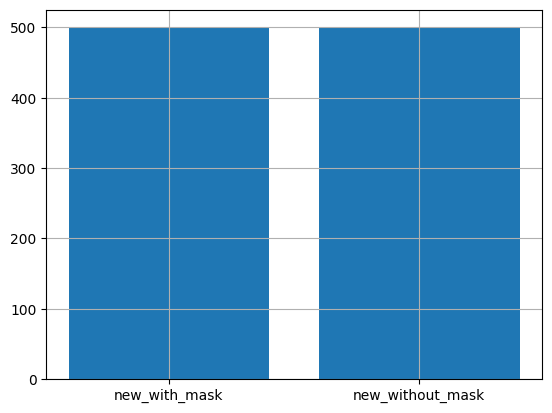

In [12]:
unique, count = np.unique(target_ssd,return_counts=True)
plt.bar(['new_with_mask','new_without_mask'], count)
plt.grid()

In [13]:
x_train_ssd, x_test_ssd, y_train_ssd, y_test_ssd = train_test_split(flat_data_ssd, target_ssd, test_size = 0.20, random_state = 100 )

**DLIB Train**

In [14]:
flat_data_dlib, target_dlib, images_dlib = model_trainer(dataset_path_dlib, category_list, itr_pic)

In [15]:
target_dlib

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

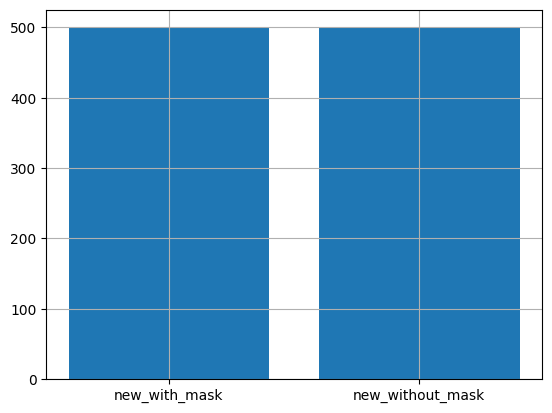

In [16]:
unique, count = np.unique(target_dlib, return_counts=True)
plt.bar(['new_with_mask','new_without_mask'], count)
plt.grid()

In [17]:
x_train_dlib, x_test_dlib, y_train_dlib, y_test_dlib = train_test_split(flat_data_dlib, target_dlib, test_size = 0.20,random_state = 100 )

**Logistic Regression on SSD**

In [18]:
lgr_ssd = LogisticRegression(max_iter=200)
lgr_ssd.fit(x_train_ssd, y_train_ssd)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [19]:
y_pred_ssd = lgr_ssd.predict(x_test_ssd)

In [20]:
y_pred_ssd

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1])

In [21]:
y_test_ssd

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1])

In [22]:
accuracy_score(y_pred_ssd, y_test_ssd)

0.845

In [23]:
cnf_matrix_ssd = confusion_matrix(y_pred_ssd, y_test_ssd)

In [24]:
cnf_matrix_ssd

array([[86, 11],
       [20, 83]])

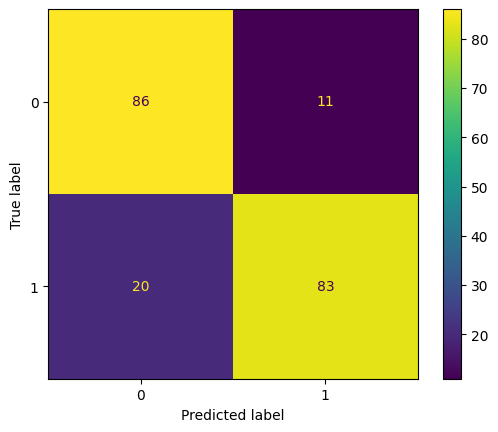

In [25]:
#plot_confusion_matrix(lgr_ssd, x_test_ssd, y_test_ssd)
ConfusionMatrixDisplay(cnf_matrix_ssd).plot()

In [26]:
print(classification_report(y_pred_ssd, y_test_ssd))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        97
           1       0.88      0.81      0.84       103

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.85      0.84      0.84       200



In [27]:
pickle.dump(lgr_ssd,open('/content/drive/MyDrive/Models/ssd_logistic_img_model.p','wb'))

**Logistic Regression on DLIB**

In [28]:
lgr_dlib = LogisticRegression(max_iter=200)
lgr_dlib.fit(x_train_dlib, y_train_dlib)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [29]:
y_pred_dlib = lgr_dlib.predict(x_test_dlib)

In [30]:
y_pred_dlib

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1])

In [31]:
y_test_dlib

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1])

In [32]:
accuracy_score(y_pred_dlib, y_test_dlib)

0.86

In [33]:
cnf_matrix_dlib = confusion_matrix(y_pred_dlib, y_test_dlib)

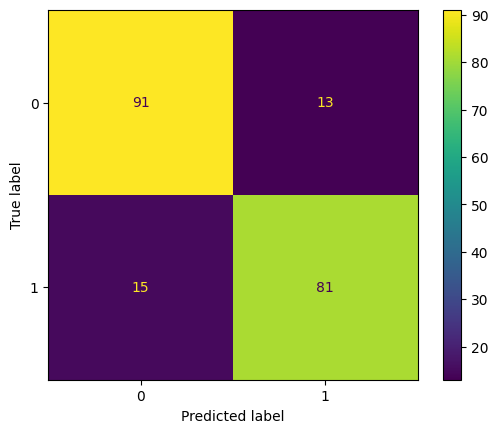

In [34]:
#plot_confusion_matrix(lgr_dlib, x_test_dlib, y_test_dlib)
ConfusionMatrixDisplay(cnf_matrix_dlib).plot()

In [35]:
print(classification_report(y_pred_dlib, y_test_dlib))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       104
           1       0.86      0.84      0.85        96

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



In [36]:
pickle.dump(lgr_dlib,open('/content/drive/MyDrive/Models/dlib_logistic_img_model.p','wb'))

**SVM on SSD**

In [37]:
svc_ssd = svm.SVC(probability=True)
svc_ssd.fit(x_train_ssd,y_train_ssd)

SVC(probability=True)

In [38]:
y_pred_ssd = svc_ssd.predict(x_test_ssd)

In [39]:
y_pred_ssd

array([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1])

In [40]:
y_test_ssd

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1])

In [41]:
accuracy_score(y_pred_ssd, y_test_ssd)

0.86

In [42]:
cnf_matrix_ssd = confusion_matrix(y_pred_ssd, y_test_ssd)

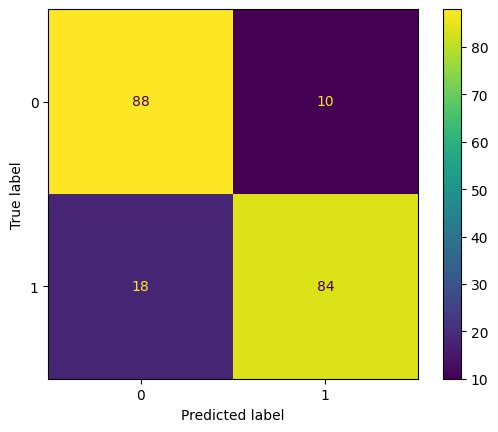

In [43]:
#plot_confusion_matrix(svc_ssd, x_test_ssd, y_test_ssd)
ConfusionMatrixDisplay(cnf_matrix_ssd).plot()

In [44]:
print(classification_report(y_pred_ssd, y_test_ssd))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        98
           1       0.89      0.82      0.86       102

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



In [45]:
pickle.dump(svc_ssd,open('/content/drive/MyDrive/Models/ssd_svm_img_model.p','wb'))

**SVM on DLIB**

In [46]:
svc_dlib = svm.SVC(probability=True)
svc_dlib.fit(x_train_dlib,y_train_dlib)

SVC(probability=True)

In [47]:
y_pred_dlib = svc_dlib.predict(x_test_dlib)

In [48]:
y_pred_dlib

array([0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1])

In [49]:
y_test_dlib

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1])

In [50]:
accuracy_score(y_pred_dlib, y_test_dlib)

0.88

In [51]:
cnf_matrix_dlib = confusion_matrix(y_pred_dlib, y_test_dlib)

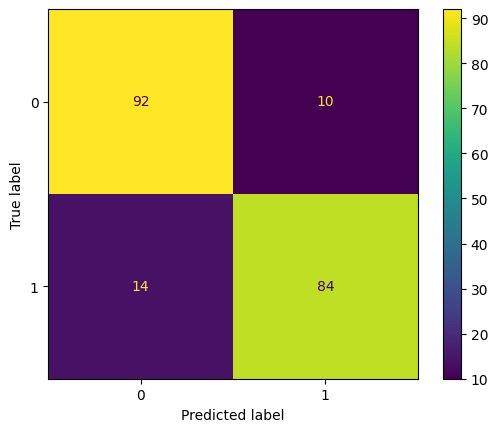

In [52]:
#plot_confusion_matrix(svc_dlib, x_test_dlib, y_test_dlib)
ConfusionMatrixDisplay(cnf_matrix_dlib).plot()

In [53]:
print(classification_report(y_pred_dlib, y_test_dlib))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       102
           1       0.89      0.86      0.88        98

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



In [54]:
pickle.dump(svc_dlib,open('/content/drive/MyDrive/Models/dlib_svm_img_model.p','wb'))

**Loading Logistic Regression Model SSD**

In [55]:
lgr_model_ssd = pickle.load(open('/content/drive/MyDrive/Models/ssd_logistic_img_model.p','rb'))

**Loading Logistic Regression Model DLIB**

In [56]:
lgr_model_dlib = pickle.load(open('/content/drive/MyDrive/Models/dlib_logistic_img_model.p','rb'))

**Loading SVM Model SSD**

In [57]:
svm_model_ssd = pickle.load(open('/content/drive/MyDrive/Models/dlib_svm_img_model.p','rb'))

**Loading SVM Model DLIB**

In [58]:
svm_model_dlib = pickle.load(open('/content/drive/MyDrive/Models/dlib_svm_img_model.p','rb'))

**Prediction Function**

In [59]:
def predict(img, ssd = False, dlib = False, lgr = False, svm = False):
  flat_data_ssd = []
  flat_data_dlib = []
  if ssd:
    ssd_face = deepcopy(img)
    # Grayscale
    img_resized_ssd = resize(ssd_face,(150,150,3))
    flat_data_ssd.append(img_resized_ssd.flatten())
    flat_data_ssd = np.array(flat_data_ssd)
    plt.imshow(img_resized_ssd)
    print('SSD')
    if lgr:
      print('Logistic Regression ', end = '')
      y_out = lgr_model_ssd.predict(flat_data_ssd)
      y_out = ['Mask Detected', 'Mask Not Found'][y_out[0]]
      print(f'PREDICTED OUTPUT: {y_out}')
    if svm:
      print('SVM ', end = '')
      y_out = svm_model_ssd.predict(flat_data_ssd)
      y_out = ['Mask Detected', 'Mask Not Found'][y_out[0]]
      print(f'PREDICTED OUTPUT: {y_out}')

  if dlib:
    dlib_face = deepcopy(img)
    img_resized_dlib = resize(dlib_face,(150,150,3))
    flat_data_dlib.append(img_resized_dlib.flatten())
    flat_data_dlib = np.array(flat_data_dlib)
    plt.imshow(img_resized_dlib)
    print('DLIB')
    if lgr:
      print('Logistic Regression ', end = '')
      y_out = svm_model_ssd.predict(flat_data_dlib)
      y_out = ['Mask Detected', 'Mask Not Found'][y_out[0]]
      print(f'PREDICTED OUTPUT: {y_out}')
    if svm:
      print('SVM ', end = '')
      y_out = svm_model_ssd.predict(flat_data_dlib)
      y_out = ['Mask Detected', 'Mask Not Found'][y_out[0]]
      print(f'PREDICTED OUTPUT: {y_out}')

**Test**

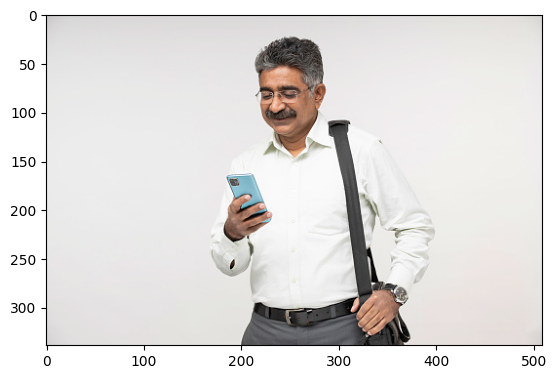

In [60]:
img = imread('https://media.istockphoto.com/photos/mature-businessman-over-white-background-stock-photo-picture-id1367477667?b=1&k=20&m=1367477667&s=170667a&w=0&h=8iKWDbvr0yvsAf_Gm-ul8svtVIBvxF61aT1XPewc1ZU=')
plt.imshow(img)

SSD
Logistic Regression PREDICTED OUTPUT: Mask Not Found
SVM PREDICTED OUTPUT: Mask Not Found


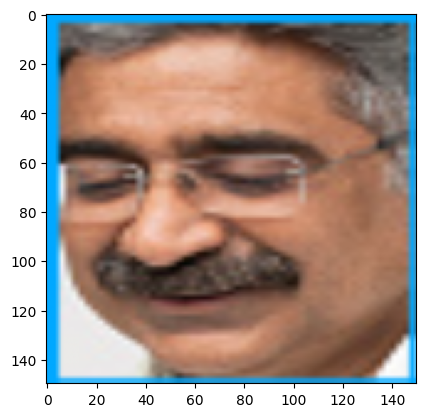

In [61]:
face_ssd, _ = detectDraw(deepcopy(img))
predict(face_ssd, ssd = True, dlib = False, lgr = True, svm = True)

DLIB
Logistic Regression PREDICTED OUTPUT: Mask Not Found
SVM PREDICTED OUTPUT: Mask Not Found


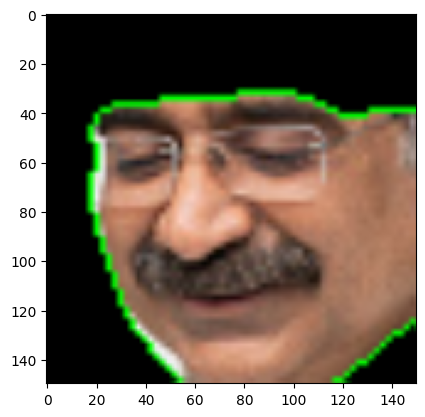

In [62]:
_, face_dlib, _ = dfacecontour(deepcopy(img))
predict(face_dlib, ssd = False, dlib = True, lgr = True, svm = True)

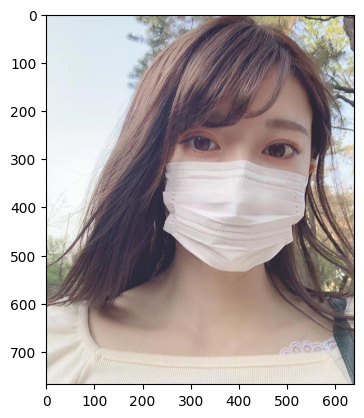

In [63]:
img = imread('https://i.pinimg.com/736x/32/02/9e/32029e0ef1ae17055cfdf4cc8b135200.jpg')
plt.imshow(img)

SSD
Logistic Regression PREDICTED OUTPUT: Mask Detected
SVM PREDICTED OUTPUT: Mask Detected


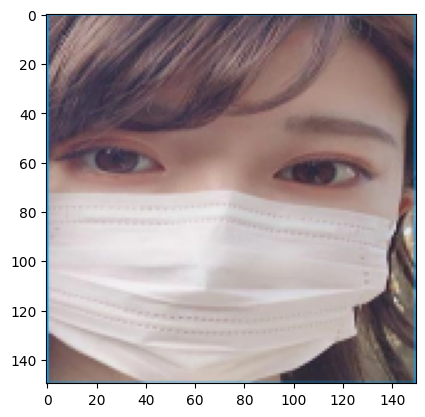

In [64]:
face_ssd, _ = detectDraw(deepcopy(img))
predict(face_ssd, ssd = True, dlib = False, lgr = True, svm = True)

DLIB
Logistic Regression PREDICTED OUTPUT: Mask Not Found
SVM PREDICTED OUTPUT: Mask Not Found


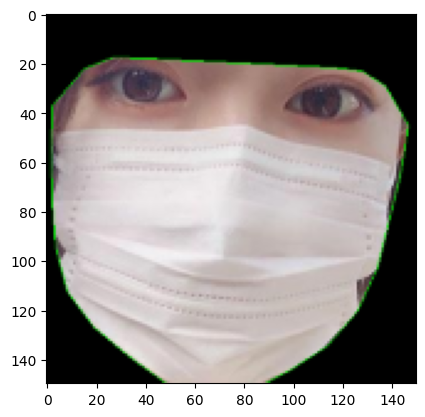

In [65]:
_, face_dlib, _ = dfacecontour(deepcopy(img))
predict(face_dlib, ssd = False, dlib = True, lgr = True, svm = True)